<a href="https://colab.research.google.com/github/sanjanb/RecurrentNeuralNetwork/blob/main/LSTM_Predicting_Service_Request_Loads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Service Request Loads

## Install & Import Libraries

In [1]:
# Install necessary packages (if not already installed)
!pip install pandas matplotlib scikit-learn tensorflow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Set a random seed for reproducibility
np.random.seed(1)
tf.random.set_seed(3)


## Load and Visualize Data

Requests    int64
dtype: object
   Requests
0       100
1       113
2       162
3       186
4       228


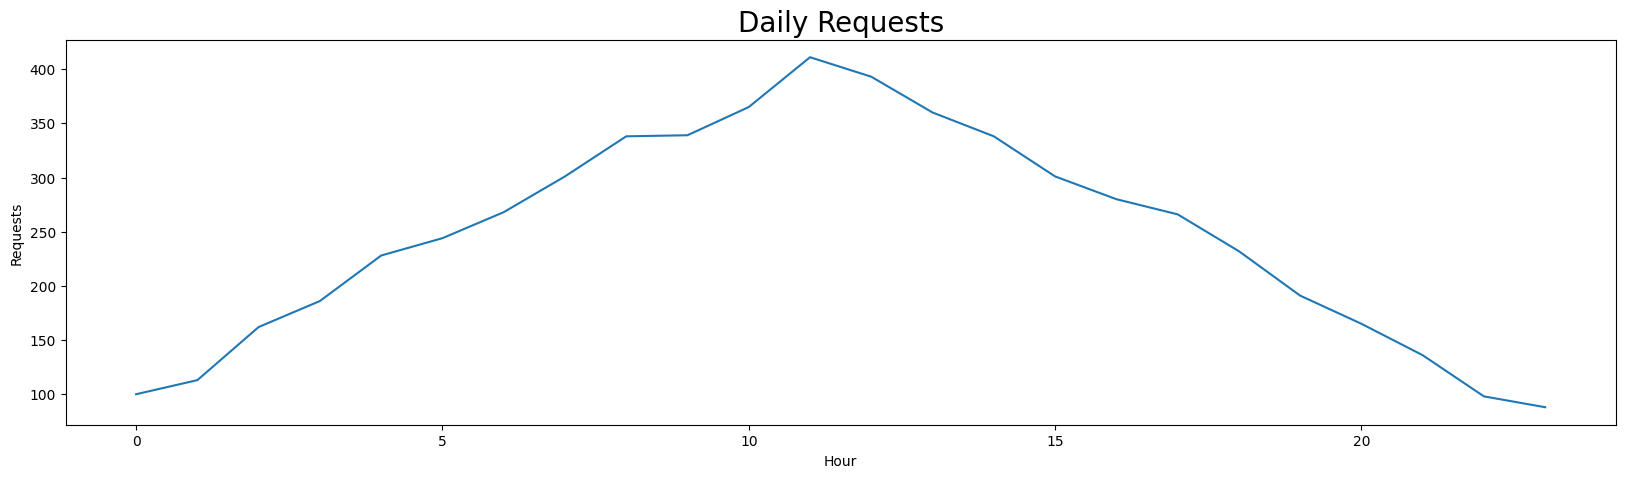

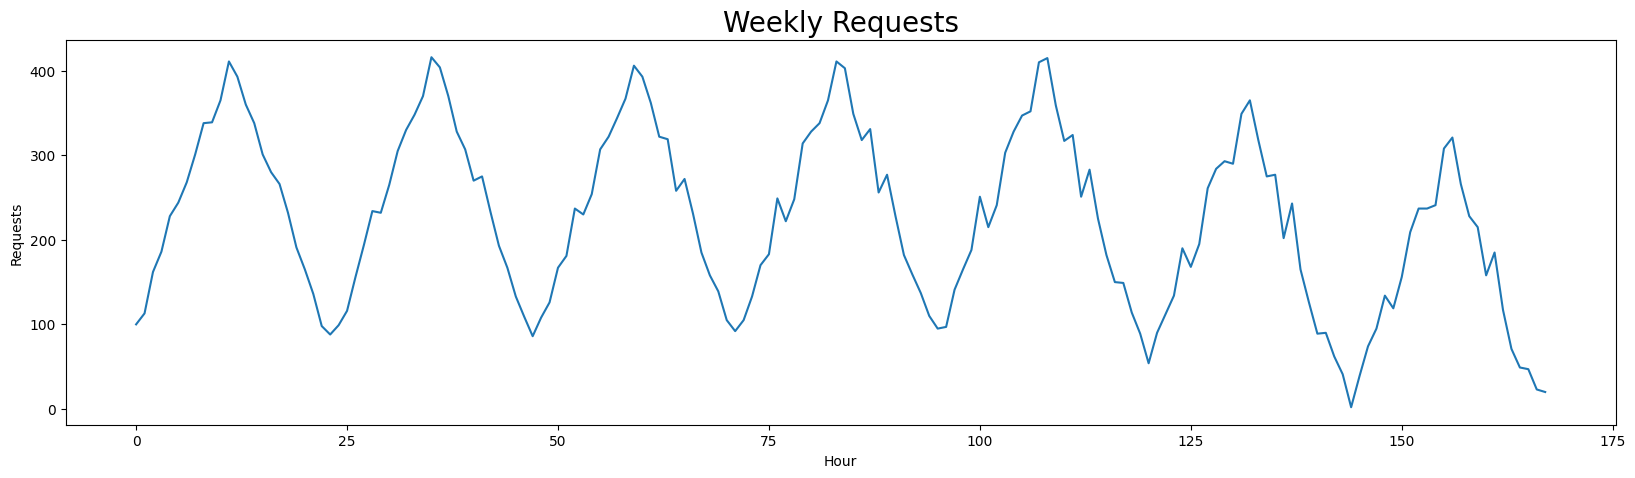

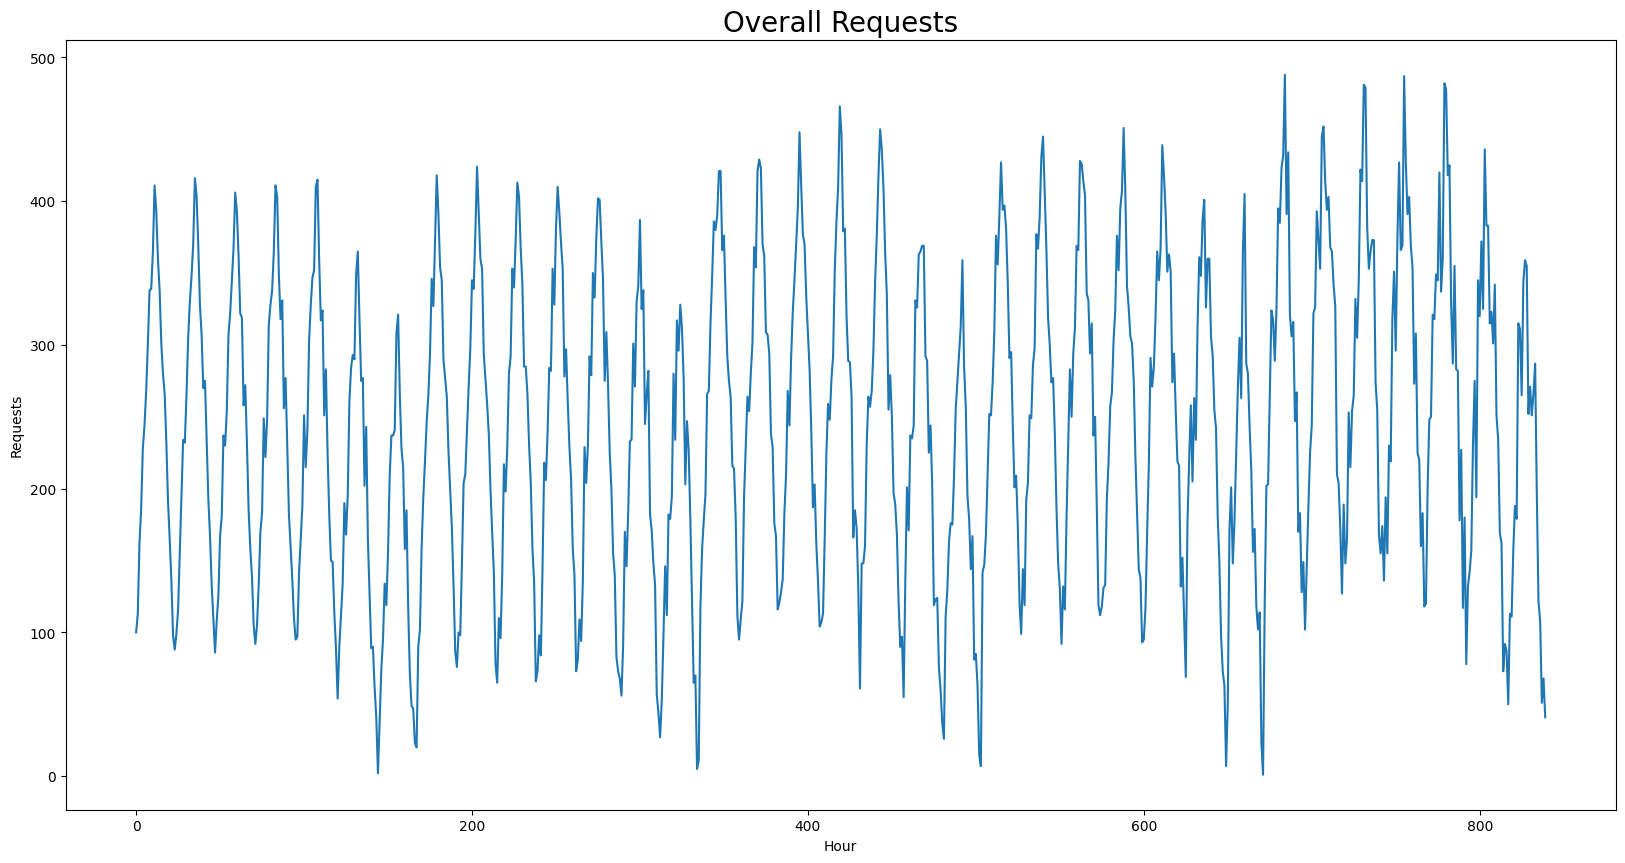

In [2]:
# Load the sequence data from CSV (ensure the file 'requests_every_hour.csv' is uploaded to Colab)
requests = pd.read_csv('/content/sample_data/requests_every_hour.csv', header=0)

# Check data types and preview data
print(requests.dtypes)
print(requests.head())

# Plot Daily Data (first 24 hours)
plt.figure(figsize=(20,5))
plt.title("Daily Requests", fontsize=20)
plt.plot(requests.head(24)['Requests'])
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.show()

# Plot Weekly Data (first 168 hours)
plt.figure(figsize=(20,5))
plt.title("Weekly Requests", fontsize=20)
plt.plot(requests.head(168)['Requests'])
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.show()

# Plot Overall Data
plt.figure(figsize=(20,10))
plt.title("Overall Requests", fontsize=20)
plt.plot(requests['Requests'])
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.show()


## Preprocess and Split Data

In [3]:
# Display the range of requests before scaling
print("Request Range before scaling:", requests['Requests'].min(), requests['Requests'].max())

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests[['Requests']])
print("Request Range after scaling:", scaled_requests.min(), scaled_requests.max())

# Define training size: first 4 weeks (24*7*4 hours)
train_size = 24 * 7 * 4

# Define lookback window as one week (24*7 hours)
lookback = 24 * 7

# Split data: training and test (add lookback for test set)
train_requests = scaled_requests[:train_size]
test_requests = scaled_requests[train_size - lookback:]
print("Shapes of Train, Test:", train_requests.shape, test_requests.shape)


Request Range before scaling: 1 488
Request Range after scaling: -2.282212823208834 2.2374886819821467
Shapes of Train, Test: (672, 1) (336, 1)


## Create RNN Dataset

In [4]:
def create_rnn_dataset(data, lookback=1):
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        # Extract 'lookback' consecutive values as input
        data_x.append(data[i:(i + lookback), 0])
        # Next value as the target
        data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

# Create training dataset
train_x, train_y = create_rnn_dataset(train_requests, lookback)
# Reshape for LSTM input: (samples, timesteps, features)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
print("Shapes of X, Y:", train_x.shape, train_y.shape)


Shapes of X, Y: (503, 1, 168) (503,)


## Build and Train the LSTM Model

In [5]:
# Build the LSTM model
ts_model = Sequential()
ts_model.add(LSTM(256, input_shape=(1, lookback)))
ts_model.add(Dense(1))

# Compile model with Adam optimizer and MSE loss
ts_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
ts_model.summary()

# Train the model
history = ts_model.fit(train_x, train_y, epochs=5, batch_size=1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         435,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 435,457 (1.66 MB)

 Trainable params: 435,457 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2194 - mse: 0.2194
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0758 - mse: 0.0758
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0627 - mse: 0.0627
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0562 - mse: 0.0562
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0501 - mse: 0.0501


## Evaluate the Model and Visualize Predictions

Test dataset shapes: (167, 1, 168) (167,)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1363 - mse: 0.1363  
Test MSE: 0.13998182117938995
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


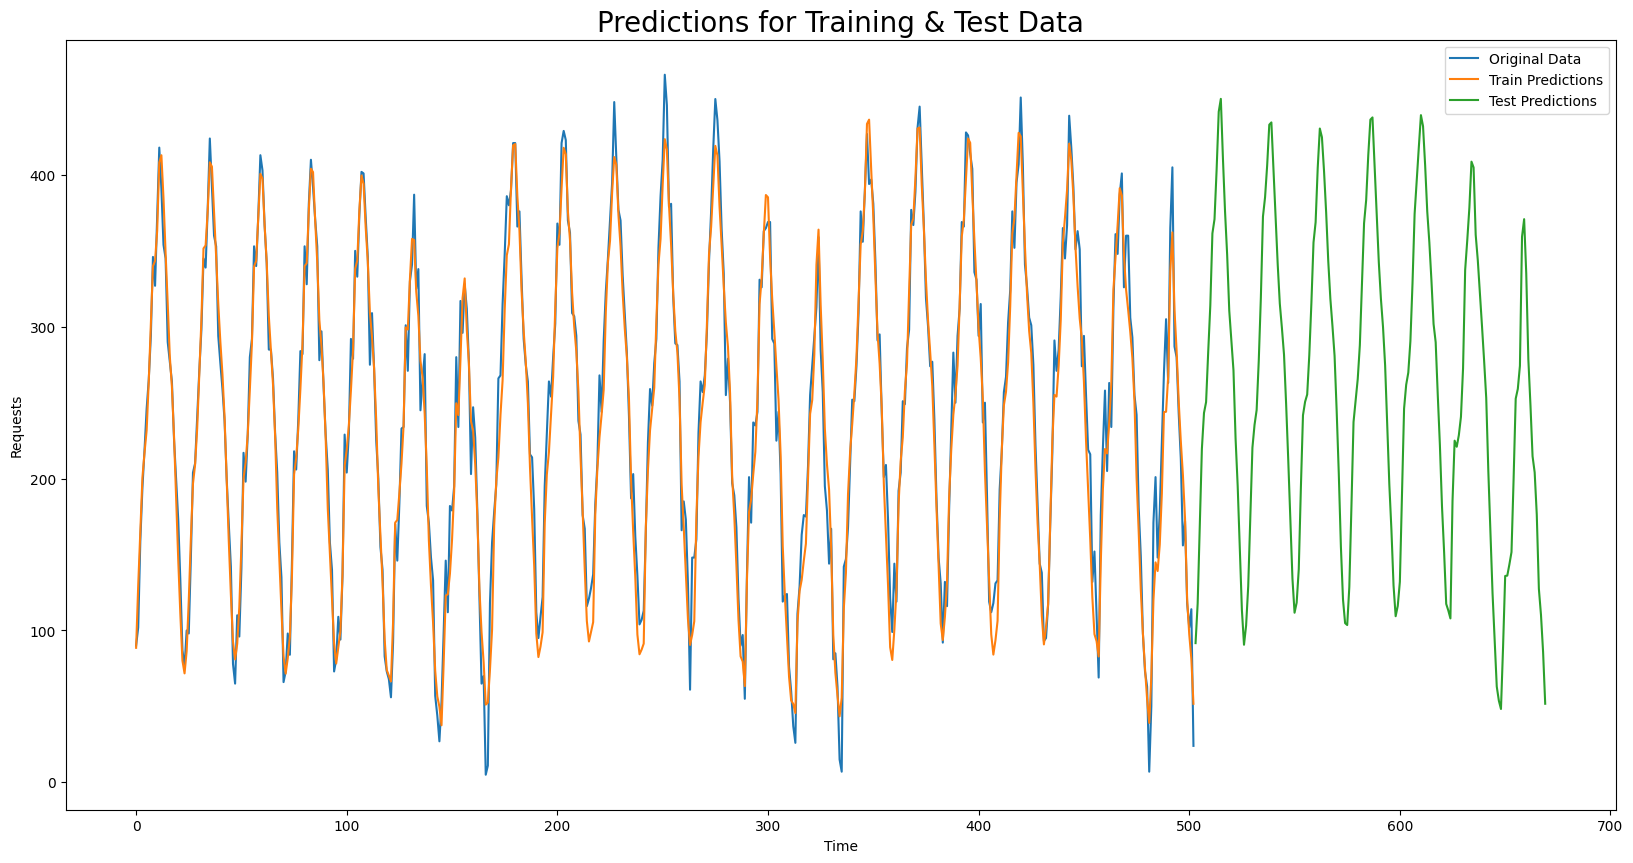

In [6]:
# Prepare the test dataset
test_x, test_y = create_rnn_dataset(test_requests, lookback)
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print("Test dataset shapes:", test_x.shape, test_y.shape)

# Evaluate the model on the test set
loss, mse = ts_model.evaluate(test_x, test_y, verbose=1)
print("Test MSE:", mse)

# Predict on training and test sets
predict_on_train = ts_model.predict(train_x)
predict_on_test = ts_model.predict(test_x)

# Inverse transform predictions to original scale
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

# Prepare original data plot (adjust indices as necessary)
total_size = len(predict_on_train) + len(predict_on_test)
orig_data = requests['Requests'].to_numpy().reshape(-1, 1)

# Create empty arrays for plotting
orig_plot = np.full((total_size, 1), np.nan)
predict_train_plot = np.full((total_size, 1), np.nan)
predict_test_plot = np.full((total_size, 1), np.nan)

# Fill in the arrays with data
orig_plot[:len(predict_on_train)] = orig_data[lookback:len(predict_on_train) + lookback]
predict_train_plot[:len(predict_on_train)] = predict_on_train
predict_test_plot[len(predict_on_train):] = predict_on_test

# Plot the predictions
plt.figure(figsize=(20,10))
plt.title("Predictions for Training & Test Data", fontsize=20)
plt.plot(orig_plot, label="Original Data")
plt.plot(predict_train_plot, label="Train Predictions")
plt.plot(predict_test_plot, label="Test Predictions")
plt.xlabel("Time")
plt.ylabel("Requests")
plt.legend()
plt.show()


## Forecast Future Service Loads

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 

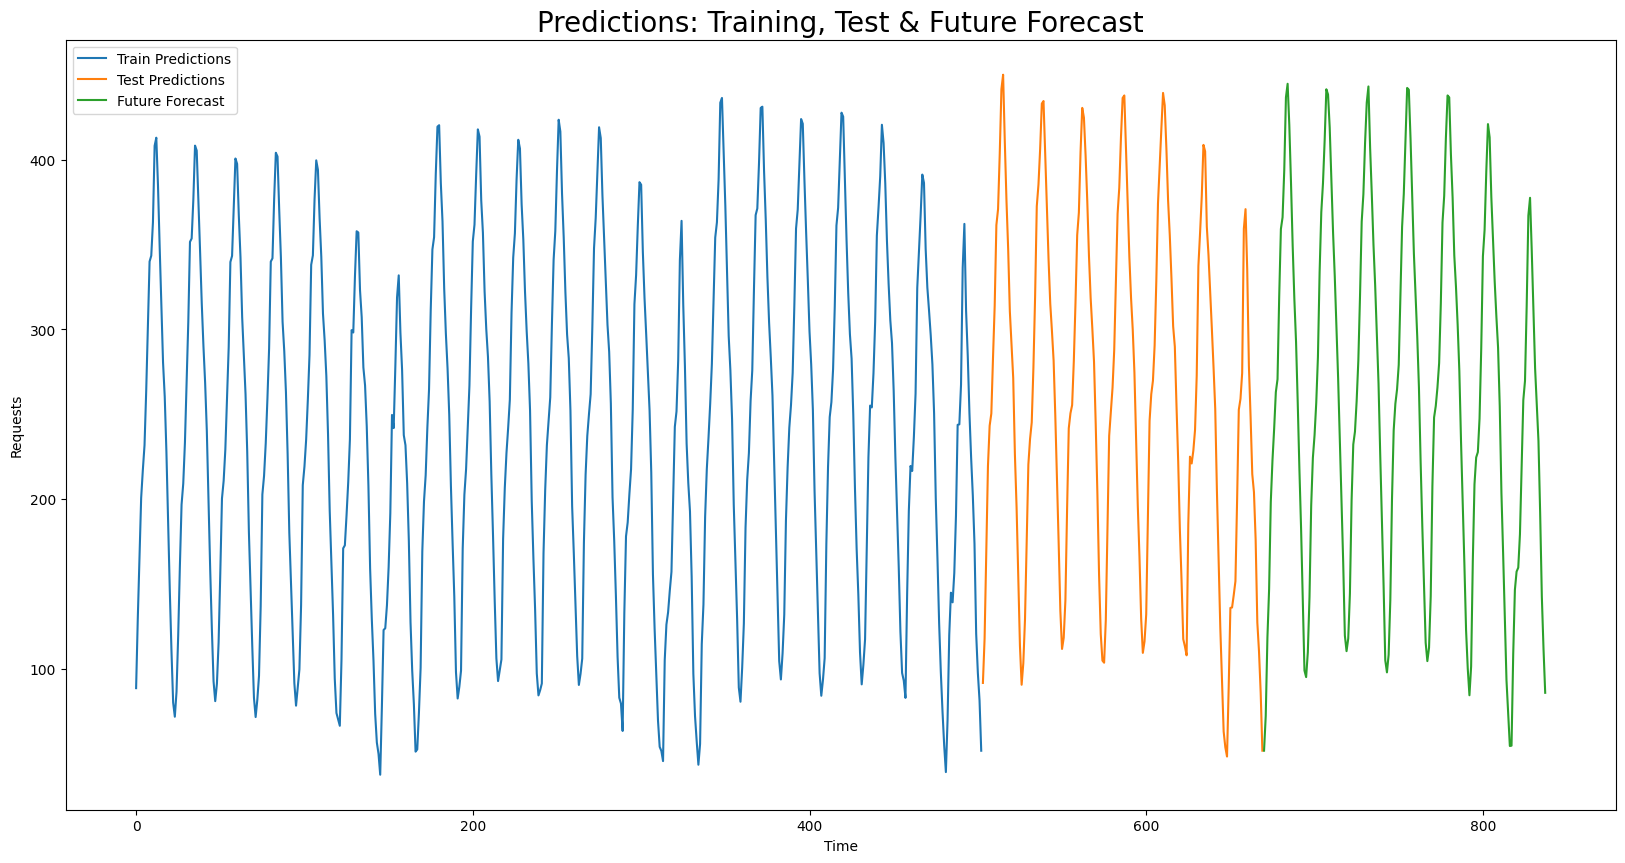

In [7]:
# Forecast future data for the next week (24*7 hours)
forecast_horizon = 24 * 7
# Start with the last available input from test data
curr_input = test_x[-1, 0, :].flatten()

# Predict future values iteratively
for _ in range(forecast_horizon):
    this_input = curr_input[-lookback:].reshape((1, 1, lookback))
    this_prediction = ts_model.predict(this_input)
    curr_input = np.append(curr_input, this_prediction.flatten())

# Extract the last forecast_horizon predictions and inverse transform them
predict_on_future = curr_input[-forecast_horizon:].reshape(-1, 1)
predict_on_future = scaler.inverse_transform(predict_on_future)
print("Future predictions (first 5):")
print(predict_on_future[:5])

# Plot training, test, and future forecasts
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)
predict_train_plot = np.full((total_size, 1), np.nan)
predict_test_plot = np.full((total_size, 1), np.nan)
predict_future_plot = np.full((total_size, 1), np.nan)

predict_train_plot[:len(predict_on_train)] = predict_on_train
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test)] = predict_on_test
predict_future_plot[len(predict_on_train)+len(predict_on_test):] = predict_on_future

plt.figure(figsize=(20,10))
plt.title("Predictions: Training, Test & Future Forecast", fontsize=20)
plt.plot(predict_train_plot, label="Train Predictions")
plt.plot(predict_test_plot, label="Test Predictions")
plt.plot(predict_future_plot, label="Future Forecast")
plt.xlabel("Time")
plt.ylabel("Requests")
plt.legend()
plt.show()
